# Natural Language Processing with Disaster Tweets

Using the dataset in: https://www.kaggle.com/c/nlp-getting-started/overview

The task is to predict if a tweet is about a natural disaster or not. Therefore, it is a typical two-class classification problem. In this notebook, the problem is tackled through the use of pre-trained BERT model as feature extractor and a simple MLP that is trained to classify the tweet. 

## Install libraries

In [4]:
# --------------- IMPORTS --------------- #
import torch
import transformers
import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch  import nn
from torch  import optim
from string import punctuation
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, DataLoader

Matplotlib is building the font cache; this may take a moment.


## Set Styles

The Seaborn library is used to plot some graphs. Here we define the color palettes.

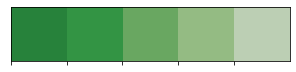

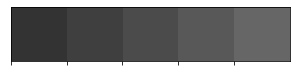

In [5]:
# Define color palettes.
greens = ['#27823b','#339444','#69a761','#94bb83','#bccfb4']
darks = ['#333333','#3f3f3f','#4b4b4b','#585858','#666666']
cmap_greens = sns.color_palette(greens)
cmap_darks = sns.color_palette(darks)
sns.set_palette(cmap_greens)

# Show the palettes.
sns.palplot(cmap_greens)
sns.palplot(cmap_darks)

In [6]:
# Set style for the figures.
sns.set_style('white')
plt.rcParams['font.family'] = 'monospace'

## BERT tokenizer

Load the BERT tokenizer and test it.

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
# Sample to test things.
sample = 'It is raining somewhere else.'

# Test BERT tokenizer.
marked_text = "[CLS] " + sample + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'it', 'is', 'raining', 'somewhere', 'else', '.', '[SEP]']


In [9]:
# Define a method to obtain the vocab IDs of the tokenized sentence and the segment IDs vector of the sentence.
def tokenize_and_segment(sentence, preprocess=False):
    if preprocess:
        sentence = ''.join([c for c in sentence if c not in punctuation]).lower()
    marked_text = "[CLS] " + sentence + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text) # A vector of 1s.
    return indexed_tokens, segments_ids

In [10]:
# Test the method.
indexed_tokens, segments_ids = tokenize_and_segment(sample, preprocess=True)
print('Tokenized sentence:\n',indexed_tokens)
print('\nSegment IDs vector:\n',segments_ids)

Tokenized sentence:
 [101, 2009, 2003, 24057, 4873, 2842, 102]

Segment IDs vector:
 [1, 1, 1, 1, 1, 1, 1]


Why do we need Segment IDs? The post https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#what-is-bert explains everything smoothly. Most of the BERT-related tasks of this notebook are based on that tutorial.

## Load pre-trained BERT and use it

In [11]:
# Load pre-trained model (weights)
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# Put the model in "evaluation" mode, meaning feed-forward operation.
bert_model.eval()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [12]:
# Method to apply the BERT model on one sentence composed of indexes of tokens and segments.
def get_hidden_states(bert_model, idx_tokens, idx_segments):
    tokens_tensor   = torch.tensor([idx_tokens])
    segments_tensor = torch.tensor([idx_segments])
    with torch.no_grad():
        outputs = bert_model(tokens_tensor, segments_tensor)
    hidden_states = torch.stack(outputs.hidden_states, dim=0) 
    return hidden_states # Output shape: [layers, batches, seq_len, features]

In [13]:
# Apply BERT and analyse the hidden_states.
hidden_bert = get_hidden_states(bert_model, indexed_tokens, segments_ids)
print('Shape of BERT hidden states: ', hidden_bert.shape)
print('Num of layers: ', hidden_bert.shape[0])
print('Num batches: ', hidden_bert.shape[1])
print('Sequence length: ', hidden_bert.shape[2])
print('Num of hidden units: ', hidden_bert.shape[3])

Shape of BERT hidden states:  torch.Size([13, 1, 7, 768])
Num of layers:  13
Num batches:  1
Sequence length:  7
Num of hidden units:  768


### Define Sentence Embeddings Extractor

In [14]:
# Average the last N layers (last_layers) of each token producing a single N-length vector.
def create_sentence_embeddings(hidden_states, layer_idx=-2):
    
    '''
    Parameters
        hidden_states: output from the BERT model.
        layer_idx: the layer to be used for obtaining the features (default=second to last layer).
    '''
    
    # Remove the batch dim, since we work with individual sentences.
    token_embeddings = torch.squeeze(hidden_states, dim=1) # Output shape: [layers, seq_len, features]
    
    # Swap dimensions 0 and 1.
    token_embeddings = token_embeddings.permute(1,0,2) # Output shape: [seq_len, layers, features]
    
    # Obtain average of features from all tokens.
    sentence_embeddings = torch.mean(hidden_states[layer_idx][0], dim=0)
    
    # Return embeddings.
    return sentence_embeddings

The function allows us to define features for a sentence using the output of the hidden states of a BERT model. Its output size is equal to $768$.

In [15]:
feature_vector = create_sentence_embeddings(hidden_bert)
print(feature_vector.shape)

torch.Size([768])


## Extracting features
Use the `create_sentence_embeddings` function as feature extractor.

In [16]:
def bert_feature_extractor(sentences, bert_model, preprocess=False, as_numpy=False, layer_idx=-2):
    
    '''
    Parameters
        sentences: list of sentences.
        bert_model: pre-trained BERT model.
        as_numpy: return tensors as numpy or not. If False, then dataset[i] is a torch tensor.
        
    Output
        dataset: a list with N tensors (torch or numpy) with features, with N=len(sentences).
    '''
    
    # Our dataset.
    dataset = []
    
    # Put the model in "evaluation" mode.
    bert_model.eval()
    
    # Go through the sentences and get the features of each.
    for sentence in sentences:
        idx_tokens, idx_segments = tokenize_and_segment(sentence, preprocess)
        hidden_bert = get_hidden_states(bert_model, idx_tokens, idx_segments)
        feature_vector = create_sentence_embeddings(hidden_bert, layer_idx)
        dataset.append(feature_vector.numpy() if as_numpy else feature_vector)
    
    # Return features list.
    return dataset 

In [17]:
sentences = ['It is dangerous to go alone, take this.', 'It is raining somewhere else.']
dataset = bert_feature_extractor(sentences, bert_model, preprocess=True, as_numpy=True)
print(len(dataset))
print(dataset[0].shape)
print(dataset[1].shape)

2
(768,)
(768,)


## Read and prepare dataset

In [18]:
# Load and see the first rows of the dataset.
df = pd.read_csv(TRAIN_FILE, sep=",")
df = df.drop(columns=['id', 'keyword', 'location'])
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


### Dataset Exploration

In [19]:
# Get the missing values.
missing = df.isna().sum()
missing = missing.sort_values(ascending=False)
missing = missing[missing>0]
missing = pd.DataFrame({'Attribute': missing.index, 'Count': missing.values})
print('Number of missing values: %d' % len(missing))

Number of missing values: 0


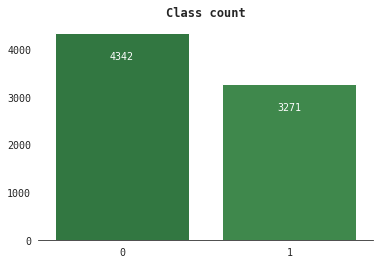

In [20]:
# Lets get the counts of each class.
counts_class = df.target.value_counts()
counts_class = pd.DataFrame({'Class': counts_class.index, 'Count': counts_class.values})

# Plot class distribution.
fig, ax = plt.subplots()
plt.title('Class count', fontweight='bold')
ax = sns.barplot(data=counts_class, x='Class', y='Count')
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(True) 

for i in range(0, len(counts_class)):
    ax.annotate(counts_class['Count'][i], 
                xy = (i, counts_class['Count'][i] - 500),
                va='center', ha='center', color='#ffff')

We can see that there is some degree of class imbalance, and we can tackle this through different approaches. However, since the difference is not that big, we will train the models using the entire dataset without any strategy to treat class imbalance. We should take one thing into account though, F1-Score must be used as metric to define how well the network performs instead of raw Accuracy.

### Extract BERT Features

In [25]:
# Forward the train set to BERT to obtain the feature vectors for each sentence.
X_train = bert_feature_extractor(sentences=df['text'], bert_model=bert_model, preprocess=True, as_numpy=True)
y_train = df['target'].tolist()
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (7613, 768)
y_train shape: (7613,)


In [26]:
# Define a dataframe to contain results and add the predictions.
df = pd.read_csv(TEST_FILE, sep=",")
X_test = bert_feature_extractor(sentences=df['text'], bert_model=bert_model, preprocess=True, as_numpy=True)
X_test = np.asarray(X_test)
print('X_test shape:', X_test.shape)

X_test shape: (3263, 768)


In [27]:
# Dump pre-processed train and test sets into numpy files.
X_TRAIN_BERT_FILE = 'X_train_bert_feat_preprocessed.npy'
Y_TRAIN_BERT_FILE = 'y_train_bert_feat_preprocessed.npy'
X_TEST_BERT_FILE  = 'X_test_bert_feat_preprocessed.npy'
np.save(X_TRAIN_BERT_FILE, X_train)
np.save(Y_TRAIN_BERT_FILE, y_train)
np.save(X_TEST_BERT_FILE,  X_test)

## Classification
Now that we have our train set prepared, let's define and apply the classifier.

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# Define the class of the model.
class Classifier(nn.Module):
    
    def __init__(self, num_units, activations, dropout=0.5):
        super(Classifier, self).__init__()
        
        # Check some errors.
        if len(num_units) != len(activations):
            print("Number of elements in num_units and activations must be the same!")
            return None
        # We can also check here if that all elements of num_units are 
        # two-dimensional, but let's trust the user ok?
        
        # Actually do the thing.
        self.layers      = nn.ModuleList()
        self.activations = nn.ModuleList()
        self.num_layers  = len(num_units) 
        for idx in range(self.num_layers): 
            self.layers.append(nn.Linear(num_units[idx][0], num_units[idx][1])) # Linear layers.
            # Activation functions.
            if activations[idx] == 'relu':
                self.activations.append(nn.ReLU())
            elif activations[idx] == 'sigmoid':
                self.activations.append(nn.Sigmoid())
            elif activations[idx] == 'softmax':
                self.activations.append(nn.Softmax(dim=1))
            else:
                self.activations.append(None)
        self.drop_layer = nn.Dropout(p=dropout) # Dropout layer.
        self.init_weights() # Init weights.

    def init_weights(self):
        initrange = 0.5
        for idx in range(self.num_layers):
            self.layers[idx].weight.data.uniform_(-initrange, initrange)
            self.layers[idx].bias.data.zero_()

    def forward(self, X, dropout=0.0):
        output = X
        for idx in range(self.num_layers): # For each layer.
            output = self.layers[idx](output) # Linear layers.
            if self.activations[idx] != None: # Apply activation function if there is any.
                output = self.activations[idx](output)
            if idx != self.num_layers - 1: # Apply dropout if it is not the last layer.
                output = self.drop_layer(output)
        return output

In [23]:
# Function to train the model for each batch.
def train(model, optimizer, criterion, dataloader, epoch):
    losses = []
    total_acc, total_count, total_loss = 0, 0, 0
    log_interval = 50
    for idx, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted = model(x).view(model(x).shape[0])
        loss = criterion(predicted, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) # Gradient clipping.
        optimizer.step()
        total_acc += (predicted.round() == y).sum().item()
        total_loss += loss / y.size(0)
        total_count += y.size(0)
        losses.append((loss / y.size(0)).view(-1).detach().numpy()[0])
        if idx % log_interval == 0 and idx > 0:
            print('| epoch {:3d} | {:5d}/{:5d} batches | accuracy {:8.3f} | loss {:8.5f}'
                  .format(epoch, idx, len(dataloader), total_acc/total_count, total_loss/total_count))
            total_acc, total_count, total_loss = 0, 0, 0
    return losses # Return a list of the value of the loss at each iteration.

### Training settings and load training data

In [29]:
# Model hyperparameters.
BATCH_SIZE    = 64      # Batch size.
EPOCHS        = 50      # Epochs.
LEARNING_RATE = 0.0005  # Learning rate.
DROPOUT       = 0.3     # Dropout.
L2_LAMBDA     = 1e-4    # Lambda for L2 Regularization.

# Model config.
INPUT_SIZE  = 768 # The size of the BERT features.
OUTPUT_SIZE = 1   # Binary classification, so the output is only one element.
num_units = [[INPUT_SIZE, 512], [512, 256], [256, OUTPUT_SIZE]]
activations = ['relu', 'relu', 'sigmoid']

In [30]:
# Load dataset with features extracted with BERT.
X_TRAIN_BERT_FILE = 'X_train_bert_feat_preprocessed.npy'
Y_TRAIN_BERT_FILE = 'y_train_bert_feat_preprocessed.npy'
X_train = np.load(X_TRAIN_BERT_FILE)
y_train = np.load(Y_TRAIN_BERT_FILE)

# Transform to torch tensor.
X_train          = torch.Tensor(X_train)
y_train          = torch.Tensor(y_train)
train_dataset    = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

In [31]:
# Model init.
model = Classifier(num_units=num_units, activations=activations).to(device)

### Main training loop

In [32]:
# Define loss function and optimizer.
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Train the network.
losses_per_epoch = []
model.train()
print('#' + '-' * 20 + ' TRAINING MODEL ' + '-' * 20 + '#')
for epoch in range(1, EPOCHS + 1):
    print('EPOCH %d ' % epoch)
    loss = train(model, optimizer, criterion, train_dataloader, epoch)
    losses_per_epoch.append(loss)

#-------------------- TRAINING MODEL --------------------#
EPOCH 1 
| epoch   1 |    50/  119 batches | accuracy    0.492 | loss  0.00358
| epoch   1 |   100/  119 batches | accuracy    0.552 | loss  0.00327
EPOCH 2 
| epoch   2 |    50/  119 batches | accuracy    0.574 | loss  0.00296
| epoch   2 |   100/  119 batches | accuracy    0.611 | loss  0.00283
EPOCH 3 
| epoch   3 |    50/  119 batches | accuracy    0.650 | loss  0.00248
| epoch   3 |   100/  119 batches | accuracy    0.666 | loss  0.00241
EPOCH 4 
| epoch   4 |    50/  119 batches | accuracy    0.682 | loss  0.00223
| epoch   4 |   100/  119 batches | accuracy    0.701 | loss  0.00216
EPOCH 5 
| epoch   5 |    50/  119 batches | accuracy    0.721 | loss  0.00208
| epoch   5 |   100/  119 batches | accuracy    0.718 | loss  0.00199
EPOCH 6 
| epoch   6 |    50/  119 batches | accuracy    0.738 | loss  0.00193
| epoch   6 |   100/  119 batches | accuracy    0.709 | loss  0.00199
EPOCH 7 
| epoch   7 |    50/  119 batches | ac

Evolution of the loss during training.

Text(0, 0.5, 'Loss')

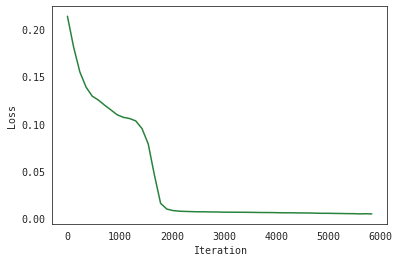

In [45]:
import matplotlib.pyplot as plt
all_losses  = []
epoch = []
loss_val = []
for i in range(0, len(losses_per_epoch)):
    # To plot all losses.
    all_losses.extend(losses_per_epoch[i])
    # To plot the average loss of each epoch.
    epoch.append(i*len(losses_per_epoch[i])) 
    loss_val.append(np.mean(losses_per_epoch[i]))
#plt.plot(all_losses)
plt.plot(epoch, loss_val, "-")
plt.xlabel("Iteration")
plt.ylabel("Loss")

Looking at the figure it seems that the network falls into a local minimum a little bit after iteration 1000. We will try to solve this in the future through some regularization techniques as well as optimizing the network's hyperparameters.

## Evaluation

In [34]:
# Function to forward the trained model and write report.
def get_model_predictions(model, dataset):
    model.eval()
    y_probs  = []
    y_preds  = []
    with torch.no_grad():
        for idx, x in enumerate(dataset):
            probs = model(x).numpy()
            y_probs.append(probs[0])
            y_preds.append(int(round(probs[0])))
    return y_probs, y_preds

In [36]:
# Load dataset with features extracted with BERT and define dataloader.
X_TEST_BERT_FILE  = 'X_test_bert_feat_preprocessed.npy'
X_test           = np.load(X_TEST_BERT_FILE)
X_test           = torch.Tensor(X_test)

# Forward.
y_probs, y_preds = get_model_predictions(model, X_test)

In [37]:
# Format results.
df = pd.read_csv(TEST_FILE, sep=",")
df = df.drop(columns=['text', 'keyword', 'location'])
df['target'] = y_preds

### Save results

In [38]:
# Names of files.
RESULTS_FILE = 'bert_nn_test_results.csv'

# Save the results and the best model.
df.to_csv(RESULTS_FILE, index=False)

### Results in the Kaggle competition
This model achieved a score equal to $0.81152$. Not bad, but also not perfect. I will try to improve this in the future. For instance, note that there is no validation split, this could be done to perform hyperparameter tuning of the network. Also note that the original dataset also contains two more attributes: keyword and location. These could be also included as input to the model to see if they can provide information to improve performance.